# Imports

In [1]:
import os
from sys import path
path.append('../')

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from src.dataset import PneumoniaDetectionChallenge

# Dataset loading for training

In [2]:
DATASET_PATH = '../datasets/rsna-pneumonia-detection-challenge/'

In [3]:
pdc = PneumoniaDetectionChallenge(DATASET_PATH)
x_train, y_train, _ = pdc.load_train_data()

In [4]:
x_train = x_train / 255.0

In [5]:
x_train = x_train.reshape(-1, 256, 256, 1)

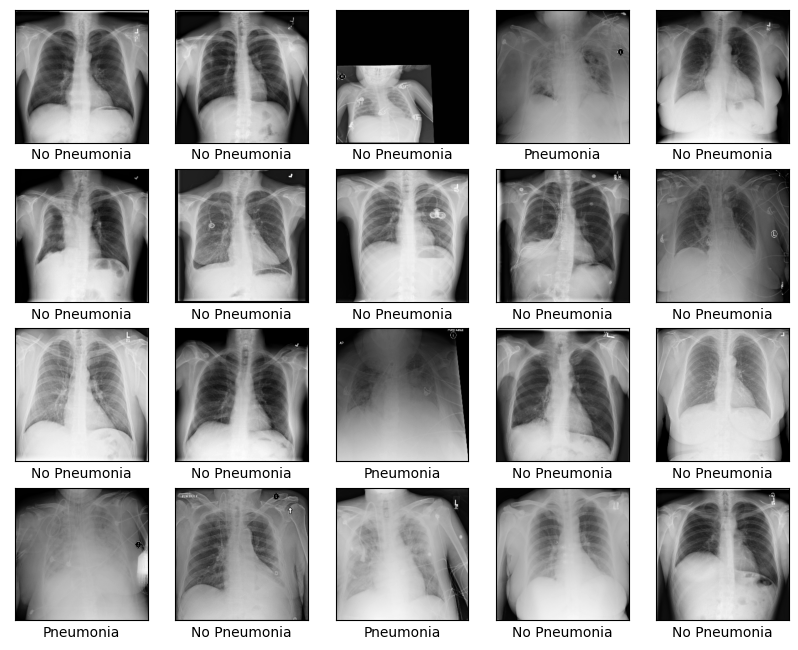

In [6]:
class_names = ['No Pneumonia', 'Pneumonia']

plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5 ,5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel(class_names[y_train[i]])
plt.show()

# Mdel definition

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [9]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Model training

In [10]:
history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
626/626 [==============================] - 33s 39ms/step - loss: 0.3882 - accuracy: 0.8593
Epoch 2/10
626/626 [==============================] - 24s 39ms/step - loss: 0.2946 - accuracy: 0.8771
Epoch 3/10
626/626 [==============================] - 24s 39ms/step - loss: 0.2852 - accuracy: 0.8769
Epoch 4/10
626/626 [==============================] - 24s 38ms/step - loss: 0.2699 - accuracy: 0.8859
Epoch 5/10
626/626 [==============================] - 23s 37ms/step - loss: 0.2488 - accuracy: 0.8952
Epoch 6/10
626/626 [==============================] - 25s 39ms/step - loss: 0.2150 - accuracy: 0.9142
Epoch 7/10
626/626 [==============================] - 24s 39ms/step - loss: 0.1719 - accuracy: 0.9335
Epoch 8/10
626/626 [==============================] - 25s 40ms/step - loss: 0.1170 - accuracy: 0.9547
Epoch 9/10
626/626 [==============================] - 25s 40ms/step - loss: 0.0776 - accuracy: 0.9704
Epoch 10/10
626/626 [==============================] - 25s 40ms/step - loss: 0.048

In [11]:
del x_train
del y_train

# Evaluating the model

In [12]:
x_test, y_test, patients_id = pdc.load_test_data()
x_test = x_test / 255.0
x_test = x_test.reshape(-1, 256, 256, 1)

In [13]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

209/209 [==============================] - 5s 21ms/step - loss: 0.8474 - accuracy: 0.8455


In [14]:
predictions = model.predict(x_test)
predictions = list(np.argmax(model.predict(x_test), axis=1))

In [15]:
test_labels_df = pdc.get_test_labels_df()

for patient_id, prediction in zip(patients_id, predictions):
    test_labels_df.loc[test_labels_df['patientId'] == patient_id, 'Prediction'] = prediction
test_labels_df.Prediction = test_labels_df.Prediction.astype(int)

In [24]:
hits = test_labels_df[test_labels_df['Target'] == test_labels_df['Prediction']].count()[1]
errors = test_labels_df[test_labels_df['Target'] != test_labels_df['Prediction']].count()[1]

In [25]:
print('General:')
print(' - Total:: ' + str(hits + errors))
print(' - Hits:: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

General:
 - Total:: 6671
 - Hits:: 5640
 - Errors: 1031
 - Hits ratio: 0.8454504572028182


In [26]:
hits = test_labels_df[(test_labels_df['Target'] == 0) & (test_labels_df['Target'] == test_labels_df['Prediction'])].count()[1]
errors = test_labels_df[(test_labels_df['Target'] == 0) & (test_labels_df['Target'] != test_labels_df['Prediction'])].count()[1]

In [27]:
print('No Pneumonia:')
print(' - Total:: ' + str(hits + errors))
print(' - Hits:: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

No Pneumonia:
 - Total:: 5796
 - Hits:: 5312
 - Errors: 484
 - Hits ratio: 0.9164941338854382


In [28]:
hits = test_labels_df[(test_labels_df['Target'] == 1) & (test_labels_df['Target'] == test_labels_df['Prediction'])].count()[1]
errors = test_labels_df[(test_labels_df['Target'] == 1) & (test_labels_df['Target'] != test_labels_df['Prediction'])].count()[1]

In [29]:
print('No Pneumonia:')
print(' - Total:: ' + str(hits + errors))
print(' - Hits:: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

No Pneumonia:
 - Total:: 875
 - Hits:: 328
 - Errors: 547
 - Hits ratio: 0.37485714285714283
